## Summary

The task of this experiment is to use PyTorch to implement multi-layer perceptron (MLP) and convolutional network (ConvNet) respectively, and complete classification on CIFAR10 data set images.  

In parameter tuning stage, we look into how kernel size, layer amount, optimizers, pooling methods etc. can affect the training results. The best CNN model chosen based on the performances on the validation set is compared with MLP and ResNet. Due to the time limit, we do not have time to go through parameter tuning on MLP and ResNet same as on CNN.

In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F  # seems to be some common practice
import torch.optim as optim

import numpy as np
from matplotlib import pyplot as plt
import time

## 1. Load CIFAR-10 

ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html  

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The classes are labeled as integers ranging from 0-9. The are: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.  

The data set is directly feteched by Pytorch CIFAR10 class. All data is normalized and converted to tensor for training.

In [2]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [3]:
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 1.1 Display Images from Dataset

ref: https://jamesmccaffrey.wordpress.com/2020/08/07/displaying-cifar-10-images-using-pytorch/  
We will display 100 images from train set, just to see if data is loaded properly.

As can seen from the below image, the result is blurry. However, we are still doing the correct read-in, since the original images are of 32 by 32 resolution, they are ment to be blurred as such.

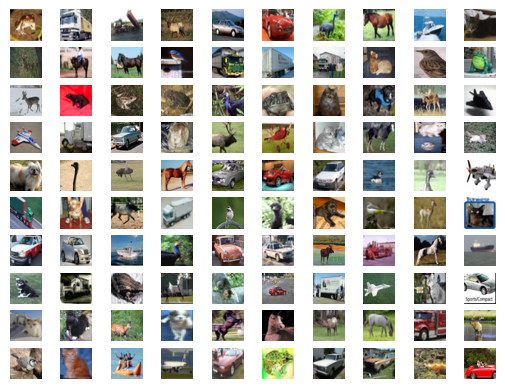

In [4]:
fig, ax = plt.subplots(10, 10) 

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=100, shuffle=False)
data_iter = iter(train_loader)

data, label = next(data_iter)

k = 0
for i in range(10): 
    for j in range(10): 
        img_data = data[k]
        img = (img_data /2 + 0.5).numpy()
        ax[i][j].imshow(np.transpose(img, (1,2,0)))
        ax[i][j].axis('off') 
        
        k += 1        
plt.show() 

### 1.2 Prepare Validation Set

ref: https://towardsdatascience.com/pytorch-basics-sampling-samplers-2a0f29f0bf2a  

We will randomly take 20% of the samples in the train set to form the validation set. Parameter tuning and model choosing will based on the validation set.  

In [4]:
validation_size = 0.2

# obtain training indices that will be used for validation
amount = len(cifar_trainset)
sample_indices = list(range(amount)) # used to track which ones are allocated to train and wich ones are validation

np.random.shuffle(sample_indices) # for random splitting

splits = int(np.floor(validation_size * amount))
train_idx, valid_idx = sample_indices[splits:], sample_indices[:splits]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

## 2. CNN

ref: https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844  
CNN's are a class of Deep Learning Algorithms that can recognize and and classify particular features from images and are widely used for analyzing visual images. A CNN architecture is usually consists of two parts:
1. A convolution tool that separates and identifies the various features of the image for analysis in a process called as `Feature Extraction`.
2. A fully connected layer that utilizes the output from the convolution and predicts based on the features extracted in previous stages.  

Below image describes a classic LeNet-5 architecture for CNN.

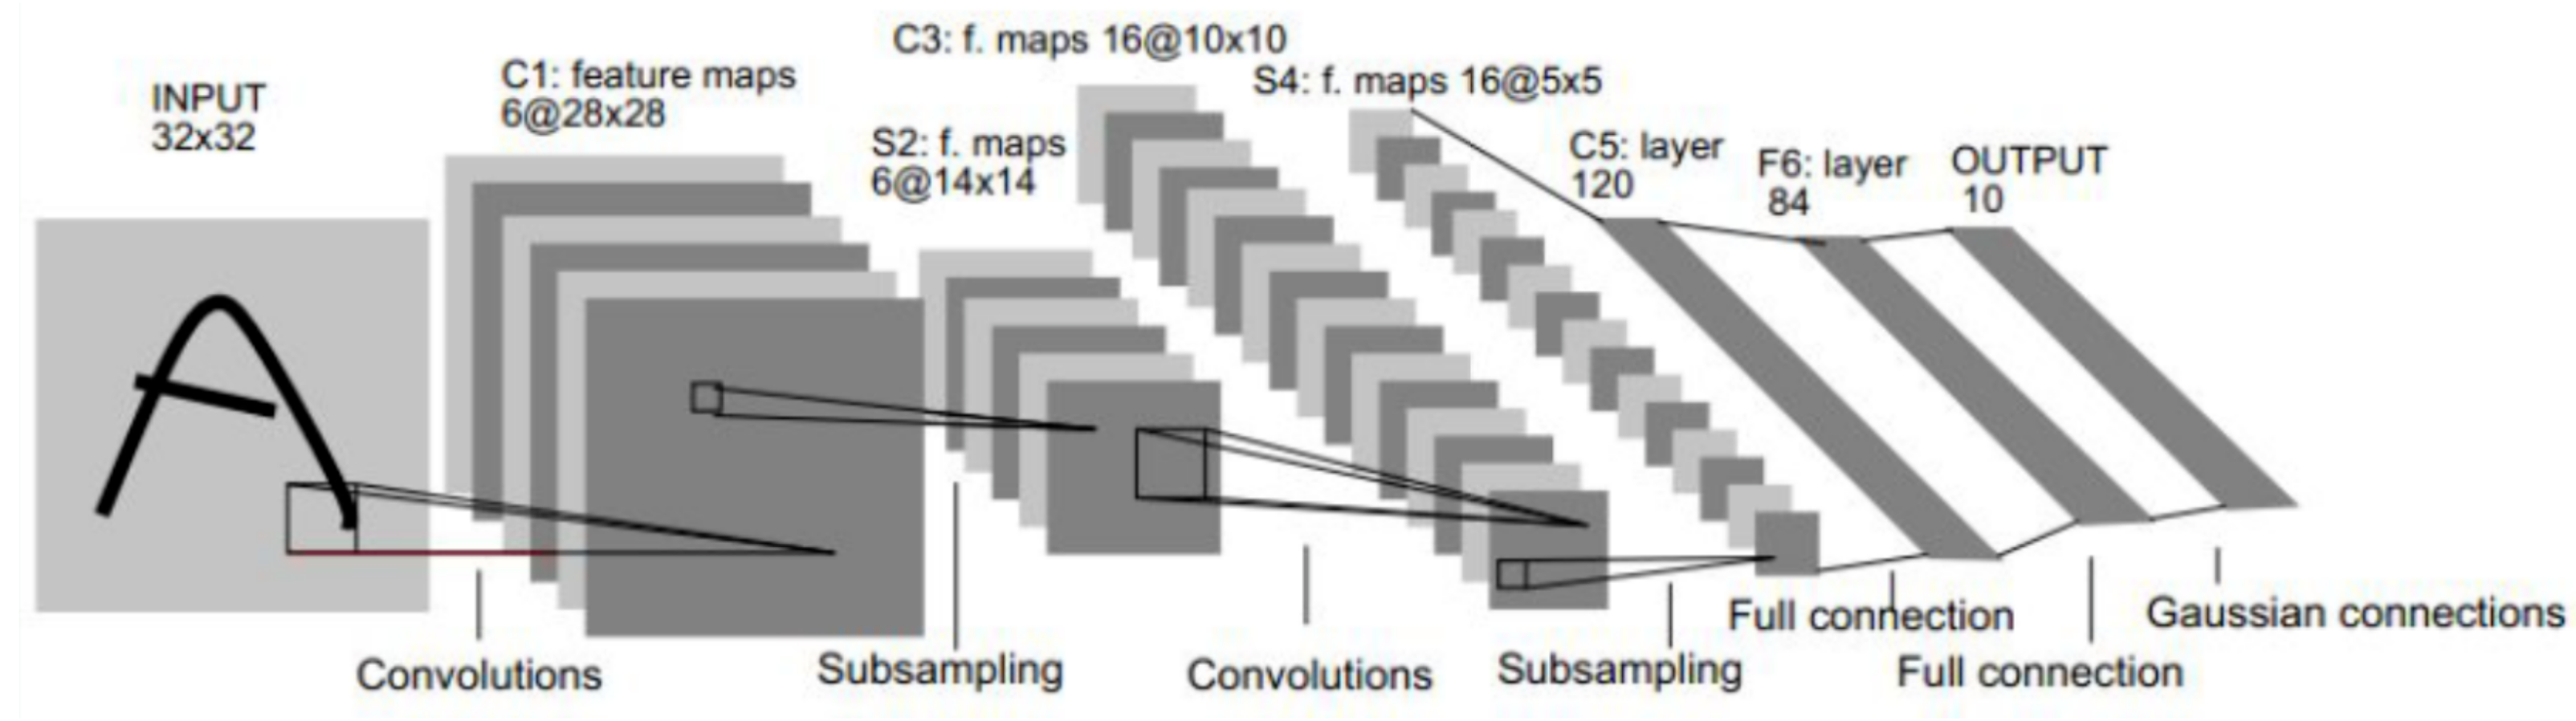

One important thing to manually construct a CNN is that, we need to calculate the output size of each lat=yer correctly, so that this could be used as in_channels and input sizes for later convolutional layers and fully connected layers.  

ref: https://medium.com/@priyankapatel2205/convolutional-neural-nets-1813eee0510  
To compute the output size of a given convolutional layer we can perform the following calculation:   
We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by (W−F+2P)/S+1.


Below is the implementation of CNN with 3 convolutional layers. The kernel sizes and layers are adjusted in the parameter tuning stage, and the below is the configuration we chosen from the tested models.

In [5]:
class CNN_Net(nn.Module):
    def __init__(self, activation='relu', drop_out=.5):
        super(CNN_Net, self).__init__()
        
        self.activation = activation

        # initialize/register convolutional layers and pooling layers
        
        # I: 3*32*32 O: 16*32*32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, stride=1, padding=3)
        # I: 16*32*32 -> Pool -> 16*16*16 O: 32*16*16
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        # I: 32*16*16 -> Pool -> 32*8*8 O: 64*8*8 -> final pool: 64*4*4
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.pool1 = nn.MaxPool2d(2, 2)  # there is also max pooling 

        # full connected layers
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        
        # dropout to avoid overfitting
        self.dropout = nn.Dropout(p=drop_out)
        
    def forward(self, x):
        if self.activation == 'relu':
            x = self.pool1(F.relu(self.conv1(x)))
            x = self.pool1(F.relu(self.conv2(x)))
            x = self.pool1(F.relu(self.conv3(x)))
            # after convolution, the train data will have batch size rows and 16*5*5 features
            x = x.view(-1, 64*4*4)
            x = self.dropout(F.relu(self.fc1(x)))
            x = self.dropout(F.relu(self.fc2(x)))
            x = self.fc3(x)
        if self.activation == 'sigmoid':
            x = self.pool1(F.sigmoid(self.conv1(x)))
            x = self.pool1(F.sigmoid(self.conv2(x)))
            x = self.pool1(F.sigmoid(self.conv3(x)))
            # after convolution, the train data will have batch size rows and 16*5*5 features
            x = x.view(-1, 64*4*4)
            x = self.dropout(F.sigmoid(self.fc1(x)))
            x = self.dropout(F.sigmoid(self.fc2(x)))
            x = self.fc3(x)
        return x

In [6]:
# calculate accuracy for prediction

def get_acc(pred, target, batch_size):
    correct = torch.eq(pred, target).sum()
    return correct/batch_size

In [31]:
def train(model, optimizer, criterion, max_epoch, batch_size, train_loader, valid_loader):
    all_train_loss, all_val_loss = [], []
    all_train_acc, all_val_acc = [], []
    
    for epoch in range(1, max_epoch+1):
        print("epoch: {}".format(epoch))
        batch_train_loss, batch_train_acc = [], []
        batch_val_loss, batch_val_acc = [], []
        
        # training
        model.train()
        # sepping through batches
        for data, target in train_loader:
            # clear the gradients
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss and acc
            batch_train_loss.append(loss.item())
            
            # make prediction
            _, pred = torch.max(output, 1) 
            batch_train_acc.append(get_acc(pred, target, batch_size))
        
        # validation
        model.eval()
        # sepping through batches
        for val_data, val_target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            val_output = model(val_data)
            # calculate the batch loss
            val_loss = criterion(val_output, val_target)

            # update training loss and acc
            batch_val_loss.append(val_loss.item())
            
            # make prediction
            _, val_pred = torch.max(val_output, 1) 
            batch_val_acc.append(get_acc(val_pred, val_target, batch_size))
            
        # get epoch average loss and acc
        all_train_loss.append(np.mean(batch_train_loss))
        all_train_acc.append(np.mean(batch_train_acc))
        all_val_loss.append(np.mean(batch_val_loss))
        all_val_acc.append(np.mean(batch_val_acc))
        
        print(all_train_loss, all_train_acc, all_val_loss, all_val_acc)
        
        
    return all_train_loss, all_val_loss, all_train_acc, all_val_acc


def test(model, optimizer, criterion, max_epoch, batch_size, test_loader):
    model.eval()
    
    all_loss, all_acc = [], []
    
    # sepping through batches
    for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)

        # update training loss and acc
        all_loss.append(loss.item())

        # make prediction
        _, pred = torch.max(output, 1) 
        all_acc.append(get_acc(pred, target, batch_size))
        
    return np.mean(all_loss), np.mean(all_acc)

### 2.1 Convolutional Layer Amount and Kernel Size

We use batch size 200, epoch 30, lr 0.01 for configurating the optimizer and solver. Nestrove for SGD is off for now, so the momentum will not bu used.
(3x3), (5x5) and (7x7) kernel sizes are tested for CNN with 2 convolutional layers and 3 convolutional layers. Pooling in this section is using average polling. And the activation function is ReLU.

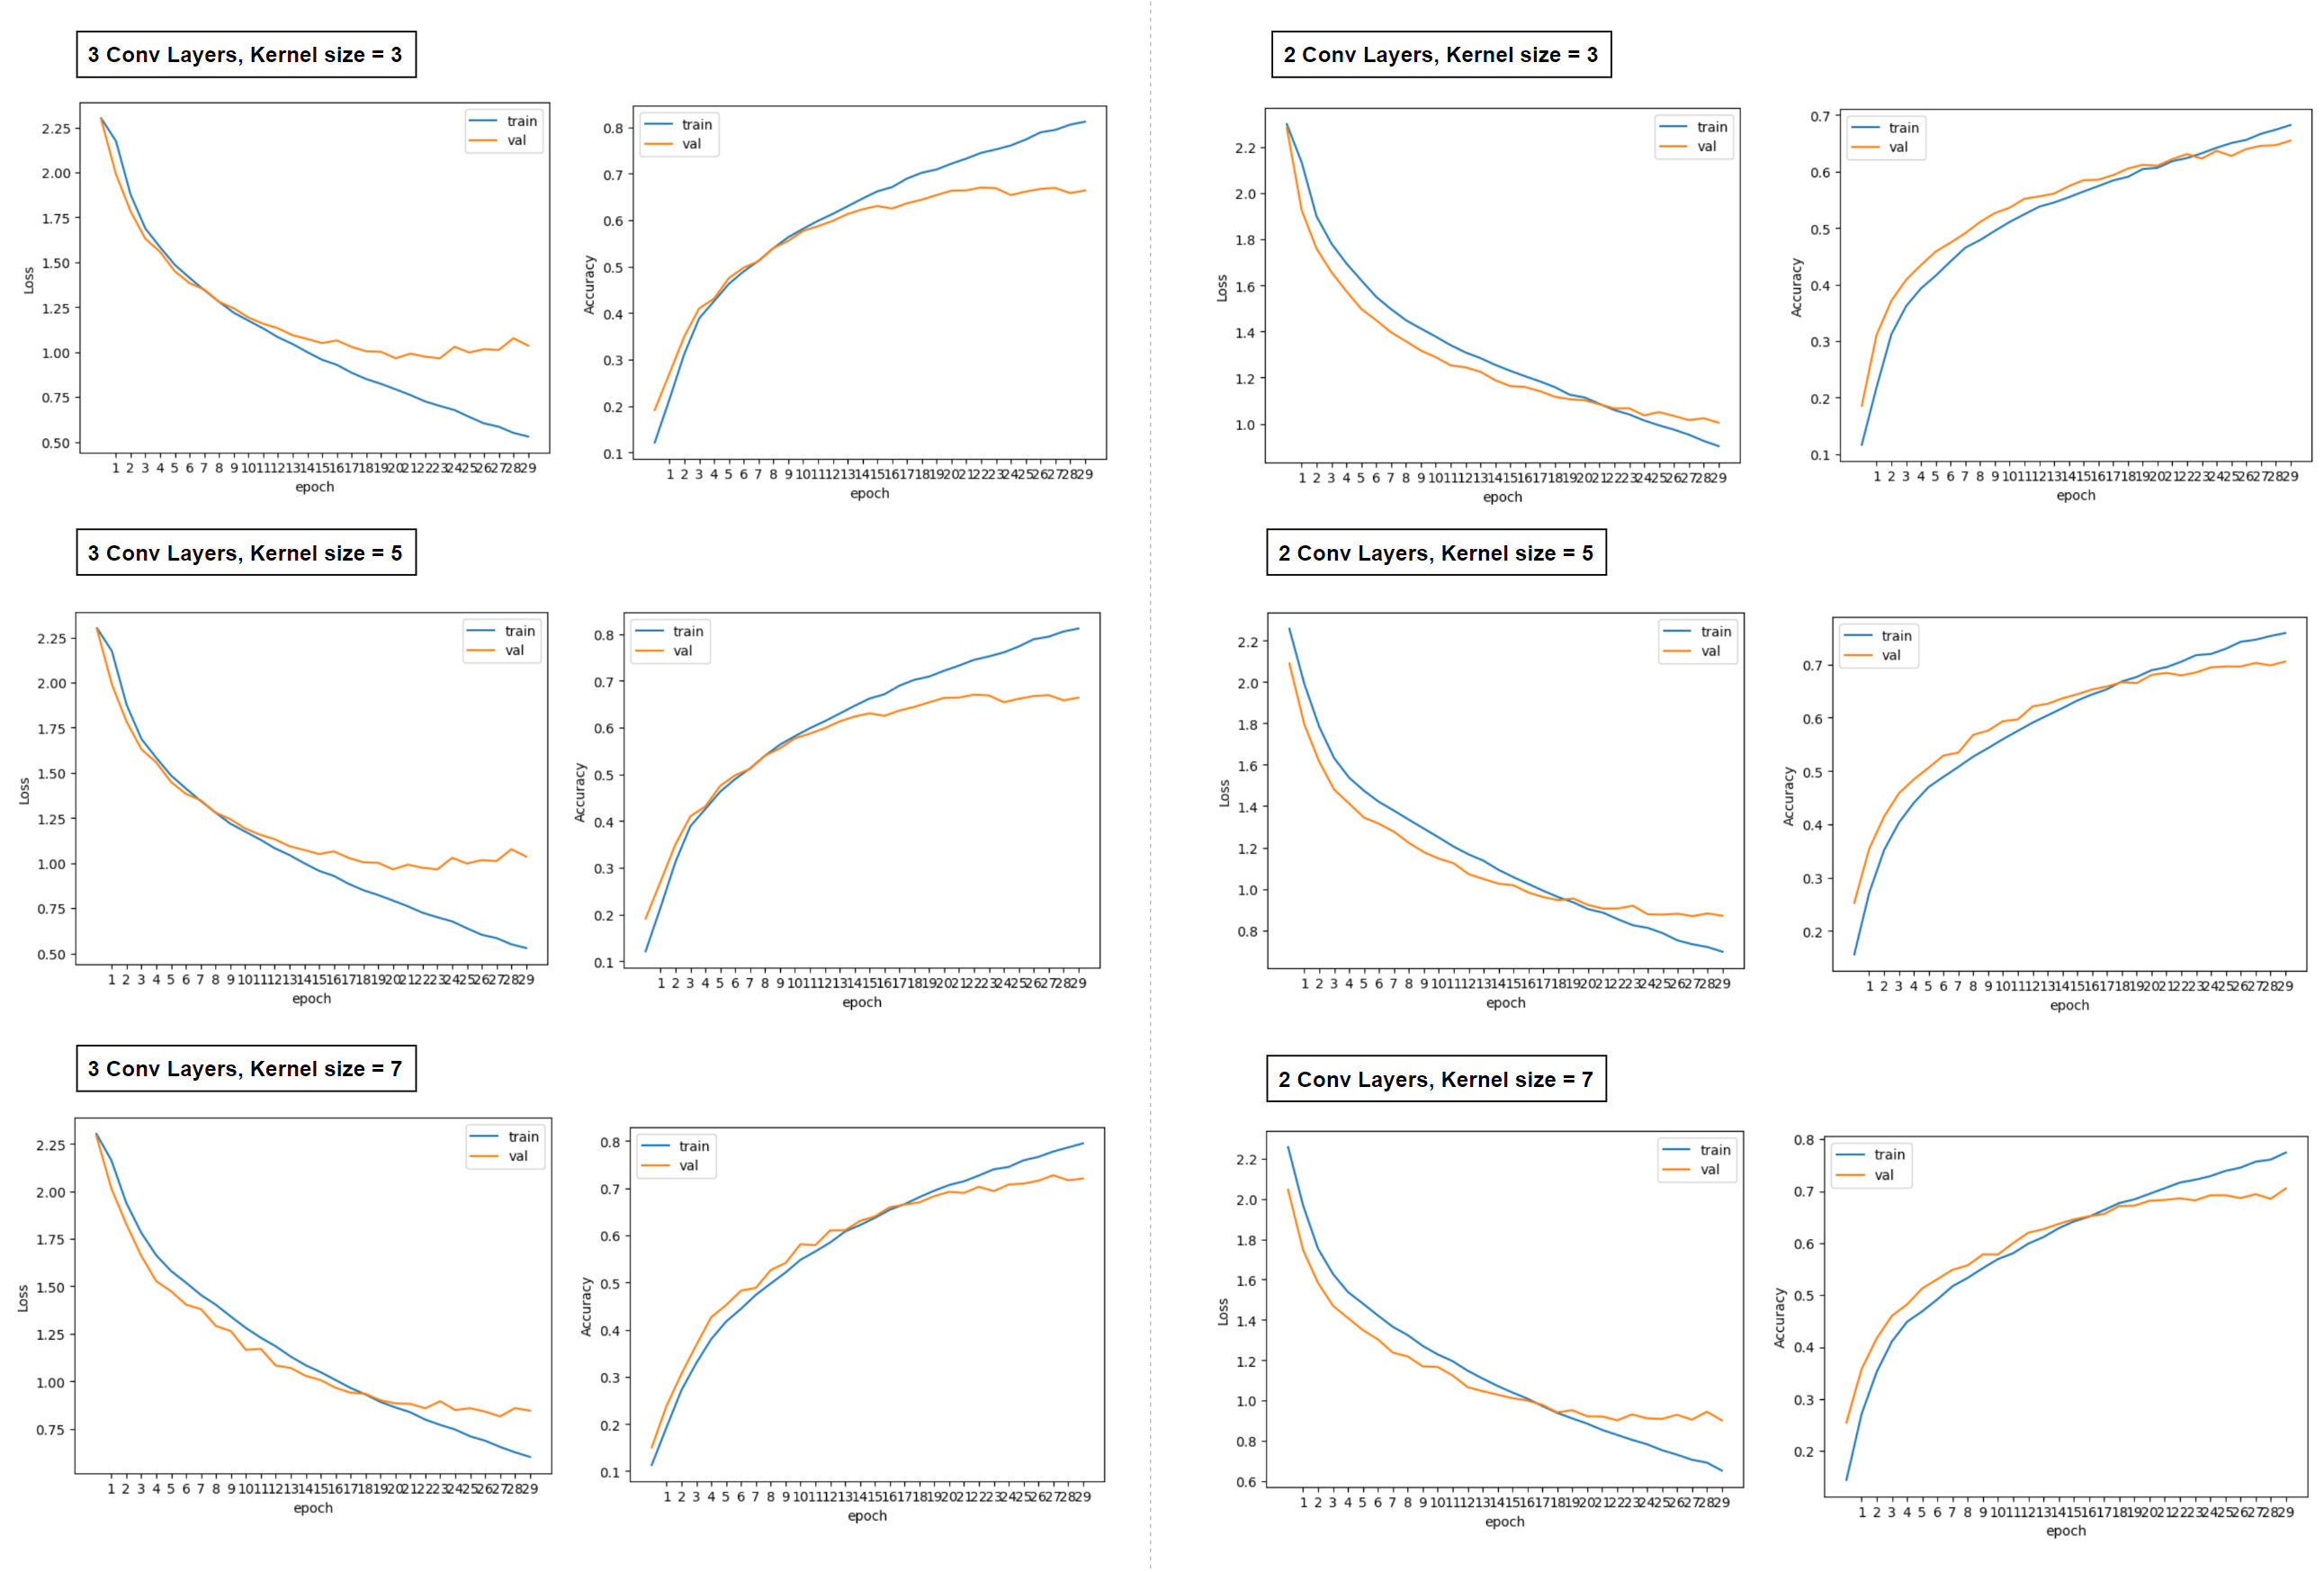  

As can seen from the image, prediction accuracy scores on the validation set are mostly fallen into 0.6-0.7 range, which is not ideal learning at all. 3 convolutional layers are generally better than 2 convolutional layers.   

The best performances for 3 convolutional layers are with (7x7) kernel size, and with 2 convolutional layers, kernel size (5x5) and (7x7) have similar results, but (5x5) is slightly better.  

Due to the accuracy being not ideal, we will need further parameter tuning.  
The activation functions, learning rate, momentum, batch size and epoch will be tested first.  

ref: https://www.quora.com/In-convolutional-neural-networks-what-effect-does-the-size-e-g-3x3-5x5-7x7-of-the-convolution-kernel-have-on-the-architecture-of-the-convolutional-neural-networks   
ref: https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15    ref: https://www.devron.ai/kbase/how-to-choose-the-optimal-kernel-size#:~:text=Increasing%20kernel%20size%20effectively%20increases,choosing%20the%20optimal%20kernel%20size.  

Convolutional neural networks work on 2 assumptions -
1. Low level features are local.
2. What's useful in one place will also be useful in other places.  

Kernel size should be determined by how strongly we believe in those assumptions for the problem at hand. In short, there is no direct connection between kernel size and predition accuracy, and there is no specific way to choose kernels' dimensions or sizes.   
Larger kernel sizes seem to have better learning results in our cases(higher accuracy, lower loss, smaller differences between train set and validation set). One way to intepret this would be that our model needs higher complaexity to address the classification rules, since increasing kernel size usually effectively increases computational complexity and the total number of parameters in the network.

### 2.2 Batch Size

Batch sizes tested are: 50, 100, 200, 500, 1000, 5000.  
We use the best performances for 3 convolutional layers and 2 convolutional layers from the above section.

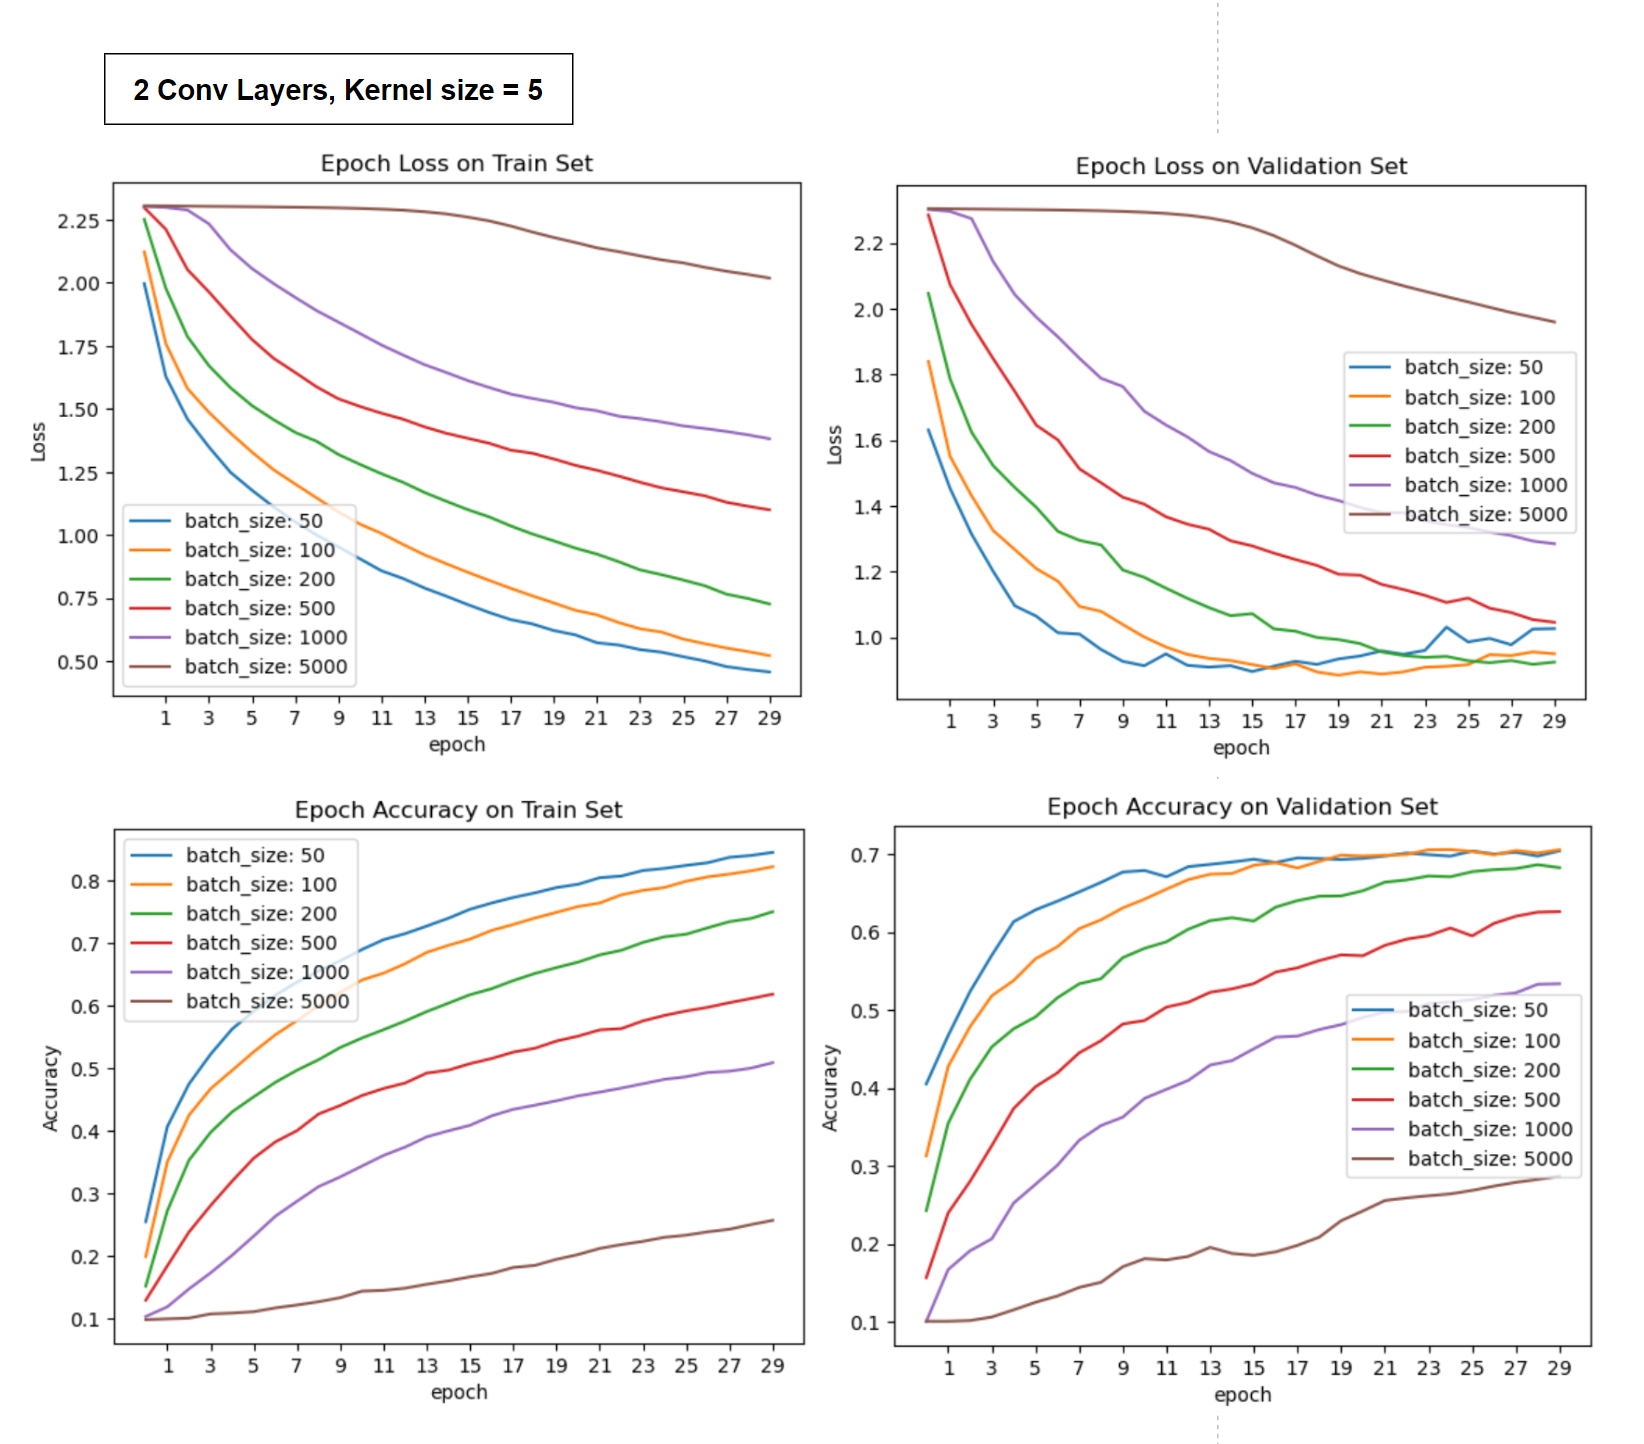
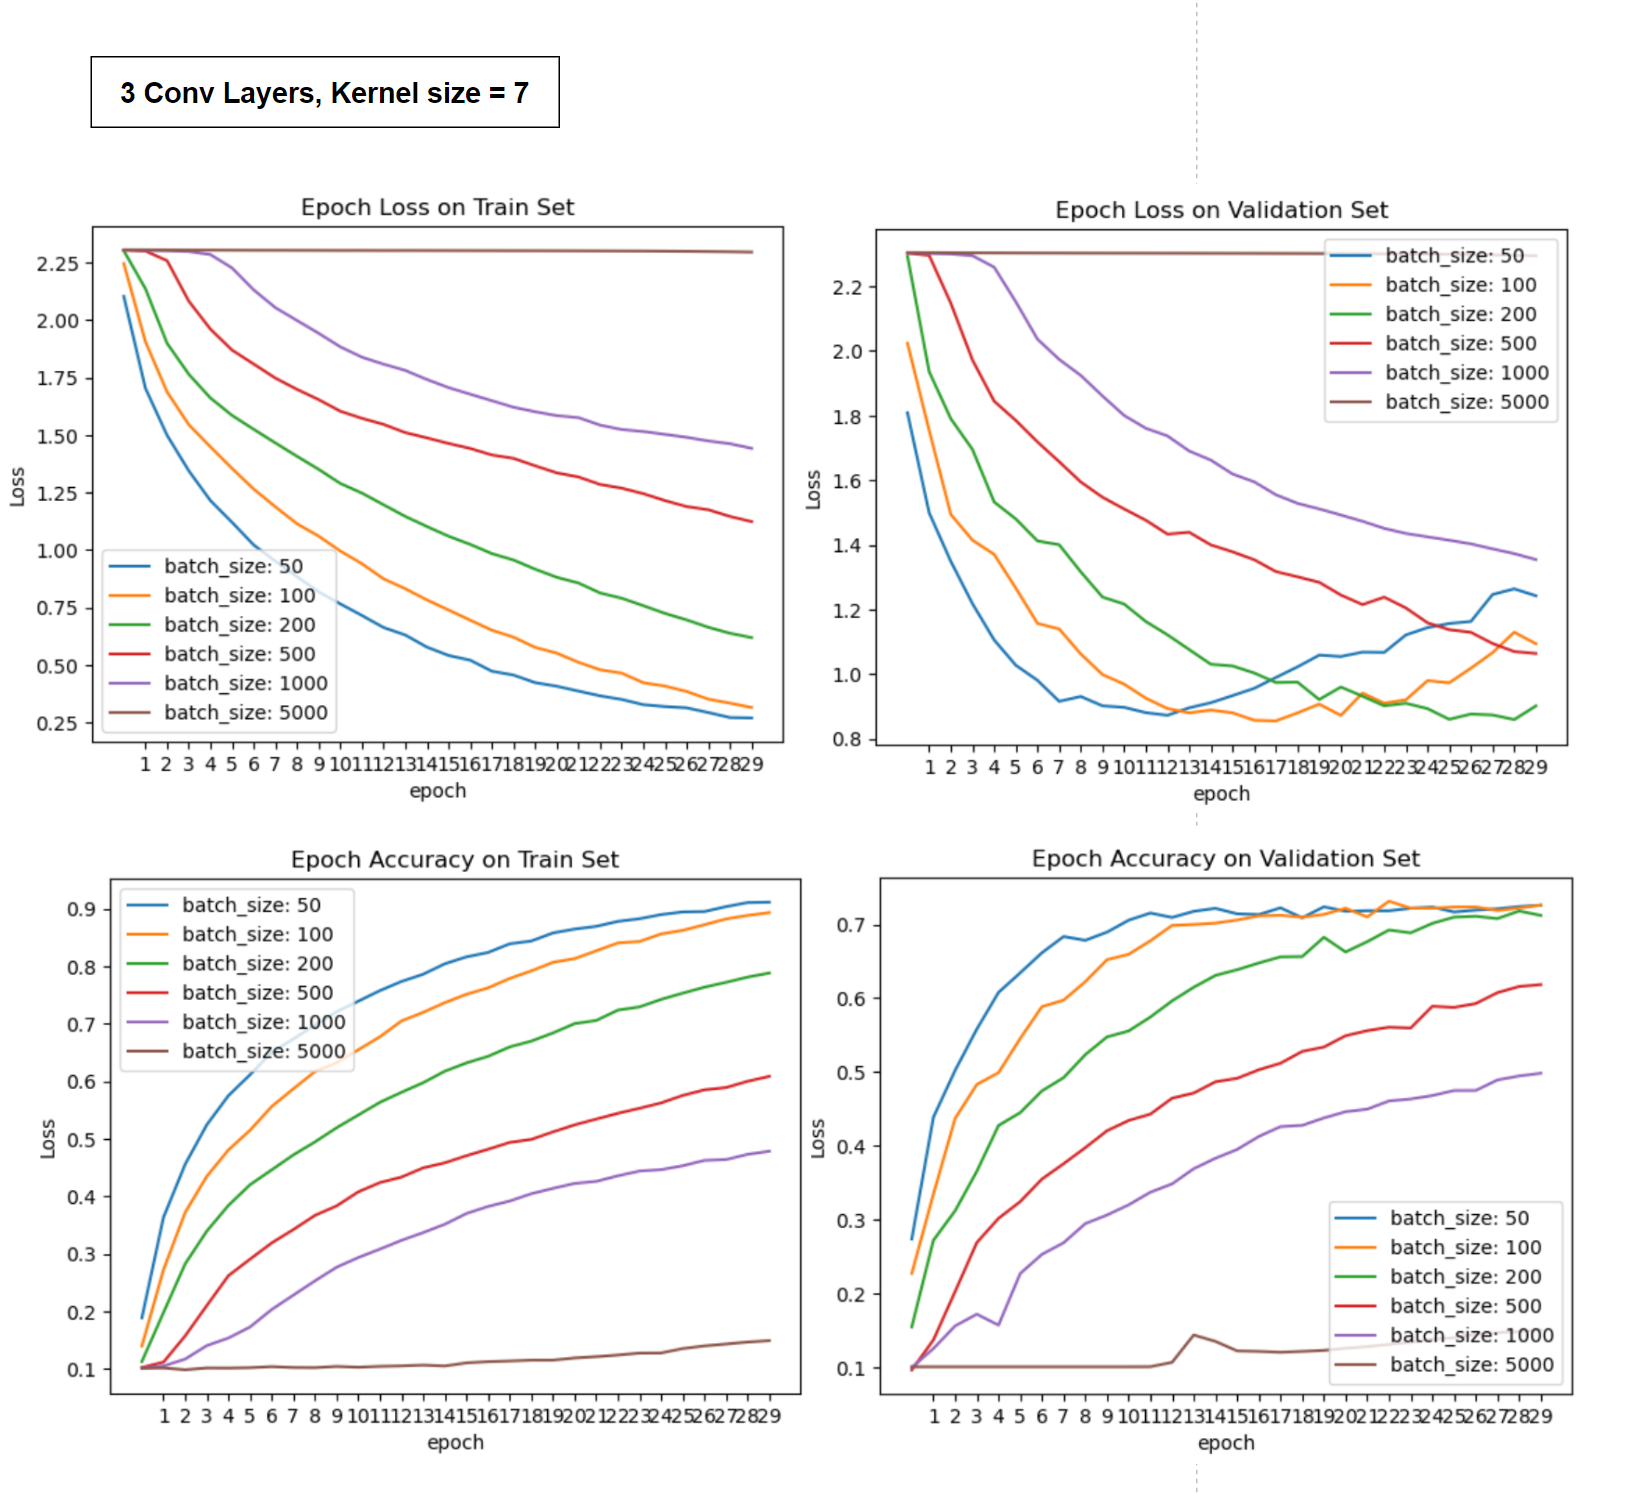

For both CNN networks, the larger the batch size, the slower the model converges, and the lower the prediction accuracy is. Both models have best performances when the batch size is 50. The CNN with 3 convolutional layers is better than with 2 convolutional layers, with higher accuracy on the validation set and lower minimum loss.   

When the batch size is set to 50, model starts to get overfitting at round epoch 12. Loss on the validation starts to rise and keeps falling oin the train set. This is because the model tries to memorize the noises and features that are irrelavant or make confusion on the classification rules. This overfitting happens with saller batch sizes: 50 and 100. Small batch size with large epochs can cause frequent local oscilliations.  

For large batch size(1000 and 5000), especially when the batch size is set to 5000, the loss curve becomes flat, this is a typical underffiting.

We will use: 3 convolution layers, 7x7 kernel size, batch size 50 and epoch 20 for later testing. In the next section, we will compare the differences momentum values going to make on the learning results.

### 2.3 Momentum

ref: https://datascience.stackexchange.com/questions/84167/what-is-momentum-in-neural-network  

For the hyperparameter combination above, we will evaluate how momentum values affect the learning results.  

When the momentum is 0.0, this means we will not introduce in any momentum to our optimization calculation, the network carries out the worst behaviour.   
The performance of the network gets better as the momentum value grows. Momentum in neural nets helps them get out of local minima points so that a more important global minimum is found.  

High momentum values also result in faster convergence. Since the nature of the momentum is to help accelerate gradients vectors in the right directions, thus leading to faster converging. Momentum accumulates the gradient of the past steps to determine the direction to go. Since experiments before all initialize models with a momentum set to 0.9, an assumption is made that when we test smaller momentum, the convergence will be slower.  

The best result is with momentum 0.9, and we can see the model starts overfitting around epoch 13. In the later section, we will still maintain the max epoch to 20, since learning rate and drop out factors can also have impact over overfitting/underfitting, and how model converges.

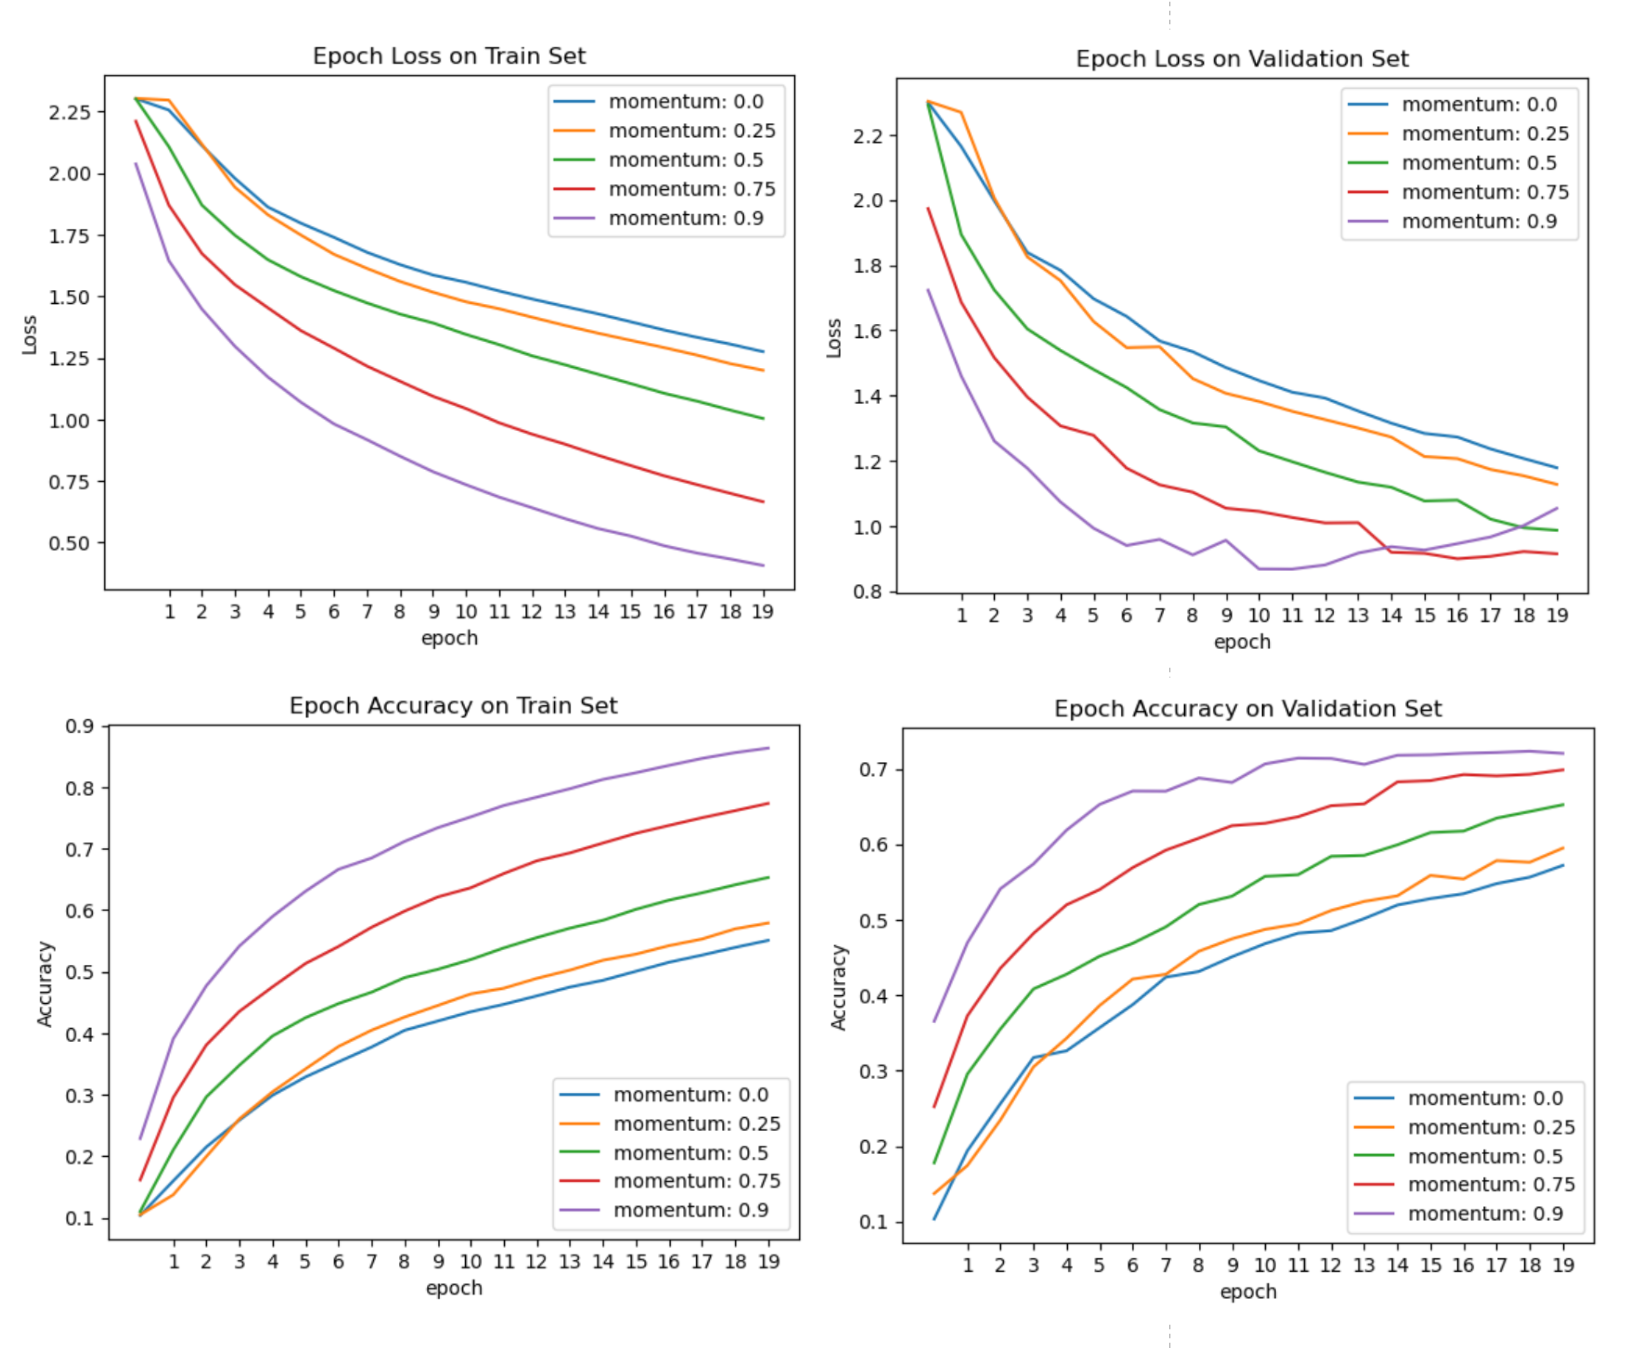  

### 2.4 Learning Rate

ref: https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/  

A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck. This is the reason why CNN networks behave badly with learning rate 0.1 and 0.0001.  

Among 0.01 and 0.001, the network has lower loss, higher accuracy and faster convergence when the learning rate is greator. A more cautious way of selecting proper learning rate would be to have smaller steps inbetween this range, but do to the time limit, we will settle with 0.01 here.

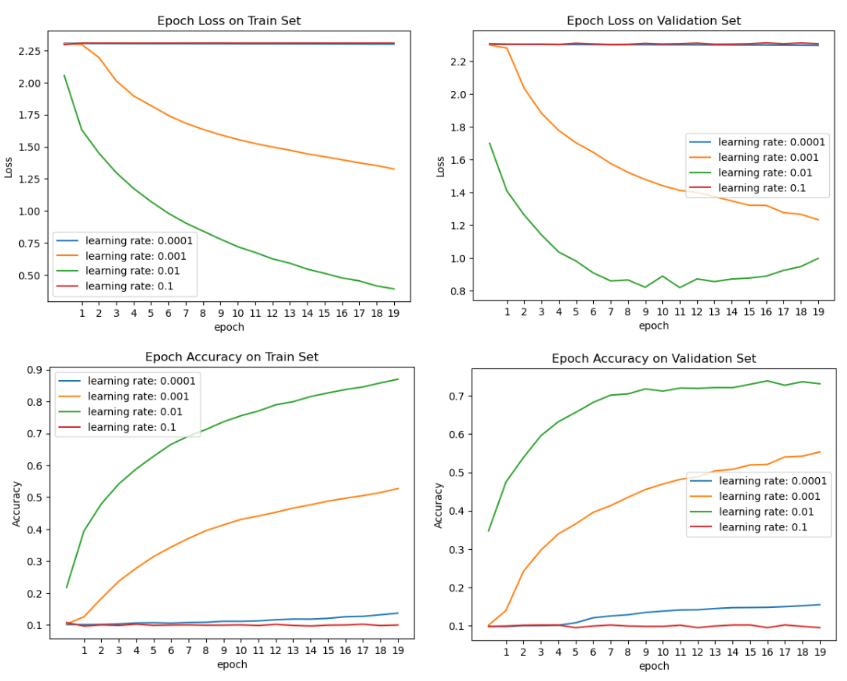

### 2.5 Drop Rate

Dropout is a technique to fight overfitting and improve neural network generalization.  
Seen from the diagrams below, we could say that smaller dropout rates produce better results for CNN network. For convolutional layers, dropout=0.5 seems too severe and the research agrees with it. See, for example, "Analysis on the Dropout Effect in Convolutional Neural Networks" paper by Park and Kwak: they find that much lower levels dropout=0.1 and dropout=0.2 work better. 

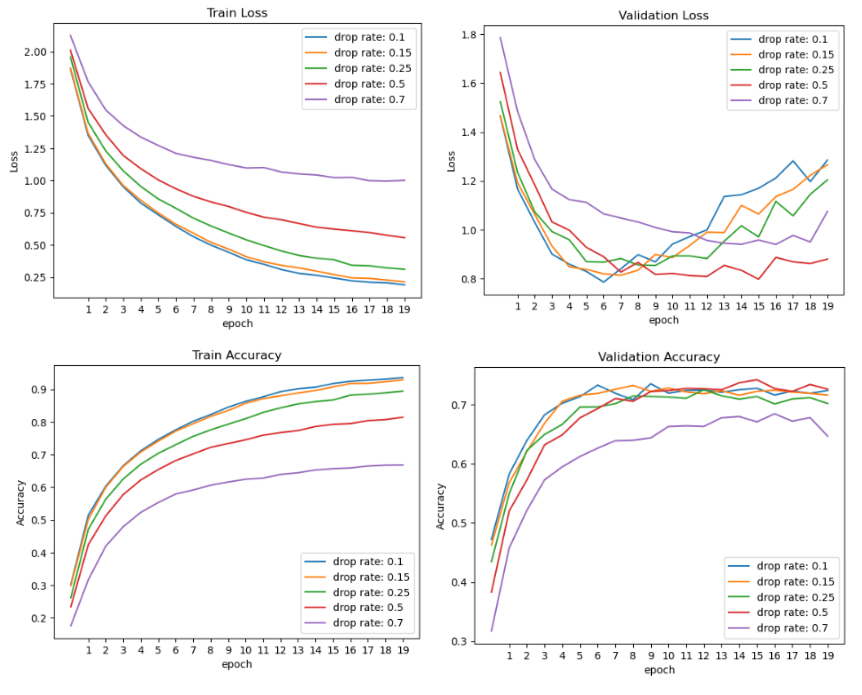  

### 2.6 Max Pooling vs Average Pooling

ref: https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/   
Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network. The pooling layer summarises the features present in a region of the feature map generated by a convolution layer.  

This has the effect of preserving the most salient features in each pooling region, while discarding less relevant information. Max pooling is often used in CNNs for object recognition tasks, as it helps to identify the most distinctive features of an object, such as its edges and corners. Whilst average pooling is on the contrary, it preserves more information than max pooling, but may also dilute the most salient features.  

In our case, since max pooling works generally better, we could make an assumption that the input data has lots of fluctuations and with the help of max pooling, the model becomes more resilent to these fluctuations.

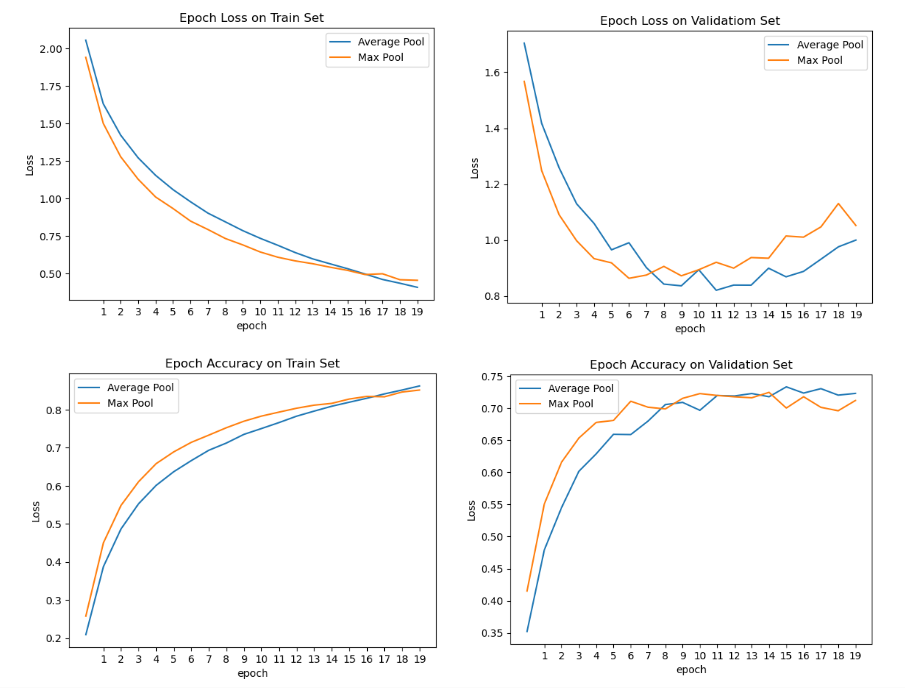

## 2.7 Kernel size changed based on layers

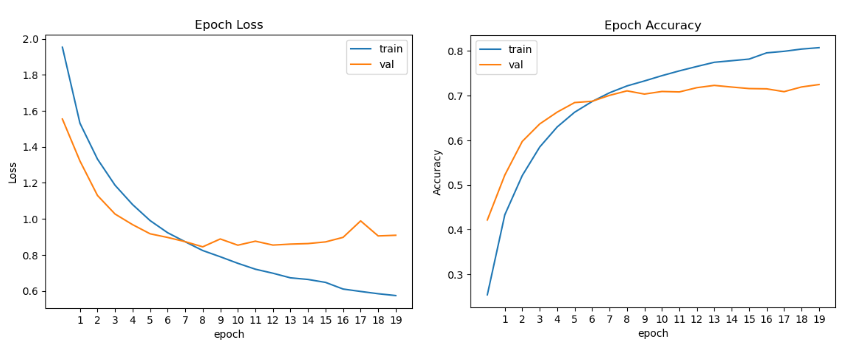

## 3. MLP

ref: https://www.linkedin.com/pulse/mlp-vs-cnn-rnn-deep-learning-machine-model-momen-negm/  

We use a simple 3 layer MLP for comparison with the CNN network. As can seen from the diagram, the loss on the validation set starts to grow at quite an early epoch(4). The highest accuracy score on the validation set is only around 0.5. MLP does not have an ideal performance on CIFAR10 image classification.   

One potential reason is that, although both MLP and CNN can be used for Image classification, MLP takes vector as input and CNN takes tensor as input so CNN can understand spatial relation(relation between nearby pixels of image)between pixels of images better thus for complicated images CNN will perform better than MLP


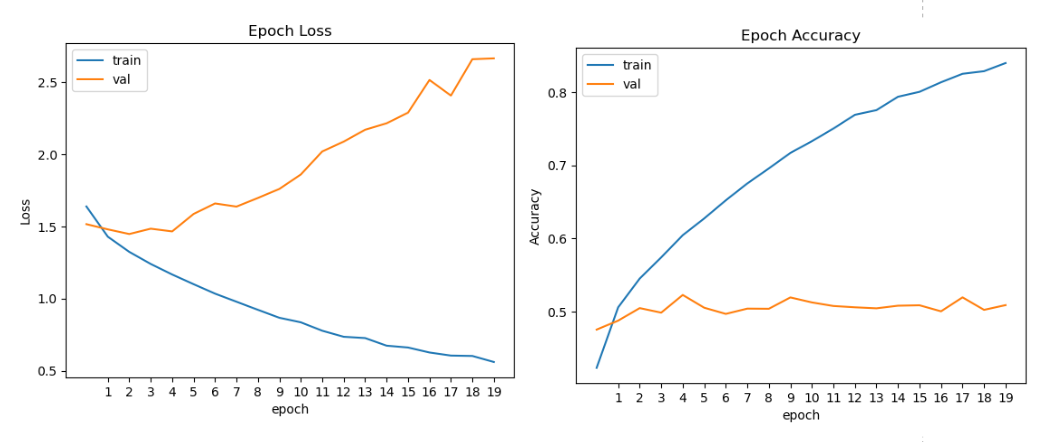

In [ ]:
# for full connect, we need to flatten the image data to 1d array

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1) 

class Flatten(nn.Module):
    def forward(self, x):
        N = x.shape[0] # read in N, C, H, W
        return x.view(N, -1) 

fc_model = nn.Sequential(
    Flatten(),
    nn.Linear(3*32*32, 1536),
    nn.ReLU(),
    nn.Linear(1536, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
)

## 4. ResNet

ref: https://www.youtube.com/watch?v=DkNIBBBvcPs

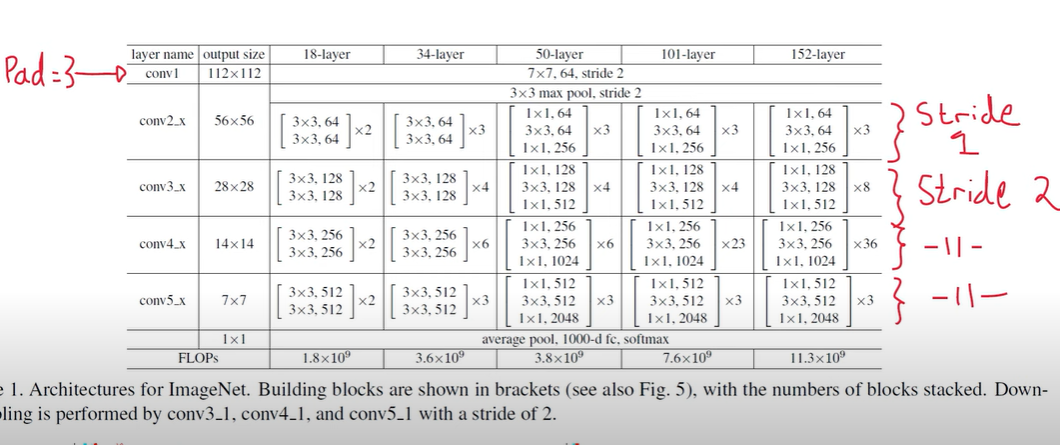  

As the network gets deeper, instead of steadily decreasing on loss, after attaining a minimum value, the error rate starts increasing again. This happens due to the exploding and vanishing gradient descent problem which also causes overfitting of the model, hence increasing the error.Residual Networks have proved to be quite efficient in solving this problem, as they use a a skip connection or a “shortcut” between every two layers along with using direct connections among all the layers. This allows us to take activation from one layer and feed it to another layer, even much deeper in the neural network, hence sustaining the learning parameters of the network in deeper layers.    

The whole ResNet code is inspired and learnt from: ‘Pytorch ResNet implementation from Scratch’(video link above). Since the time budget for this assignment is quite limited, we do not have time for parameter tuning and run tests regarding the ResNet algorithm, and the prediction result is not ideal. 

In [8]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

def ResNet18(img_channel=3, num_classes=10):
    return ResNet(block, [2, 2, 2, 2], img_channel, num_classes)
    
def ResNet50(img_channel=3, num_classes=10):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=10):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=10):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=128, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=128, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=128)


model = ResNet50(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

train_loss, val_loss, train_acc, val_acc = train(
    model, optimizer, criterion, 10, 128, train_loader, valid_loader
)

## 5. Conclusion




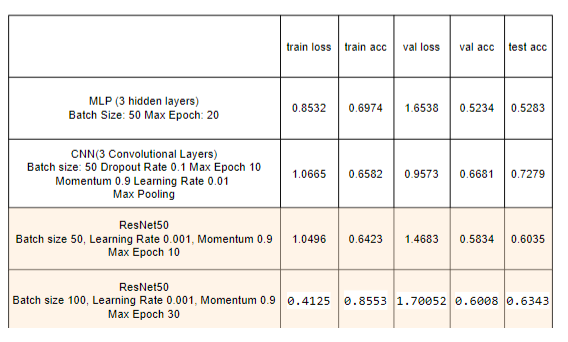
The task of the experiment is to use PyTorch to implement multi-layer perceptron (MLP) and convolutional network (ConvNet) respectively, and complete classification on CIFAR10 dataset images. 

In the parameter tuning stage, we look into how kernel size, layer amount, optimizers, pooling methods etc. can affect the training results. The best CNN model chosen based on the performances on the validation set is compared with MLP and ResNet. Due to the time limit, we do not have time to go through parameter tuning on MLP and ResNet, the same as on CNN.  

The best performance with 3 convolutional layers we constructed reaches 72.79% accuracy on the test set.  The hyperparameters at this occasion are: dropout rate 0.1, learning rate 0.01, momentum 0.9, batch size 50, max epoch 10 with max pooling. The MLP reaches the highest accuracy 52.83% on the test set. As for the ResNet we test, the prediction accuracy is not ideal(seen from the above diagram). Among all these tracked models, the 3-convolutional-layers CNN has the best learning results. However, ResNet by theory should be better than classic LeNet-5, since ResNet is known as one of the most efficient Neural Network Architectures, as they help in maintaining a low error rate much deeper in the network[12]. Our experiment has such conflicting results due to the fact that we have not found the proper parameter settings within the limited tests we run for ResNet. 
To improve the learning, we could test more on the ResNet model and try to find out the hyperparameter that leads to a global minimum convergence. Besides working on the network parameters only, we should also consider data preprocessing on the images, such as image flipping, contrast enhancing, brightness adjustment and so on.   

At the time this assignment is handed in, experiments and tests are still running. Due to the limitation of time, although not being able to complete all planned experiments and achieve ideal prediction accuracy, we will keep working on this afterwards on our own for better understanding over the convolutional neural network. 
